In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pandas as pd
import numpy as np
import pycountry
from scipy.optimize import least_squares
import math
import random
import statsmodels
from scipy.optimize import minimize
from scipy.optimize import fsolve
#from pandas.core import datetools
import statsmodels.api as sm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from math import pi, e
import model_functions as mf
import build_data_functions as bdf
import plot_model_functions as pmf
import matplotlib.pyplot as plt
import plot_data_functions as pdf
import spatial_error_model as sem

In [2]:
years = list(range(2005, 2017))

In [3]:
y = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/resident_foreigners_norm.csv", sep = "\t", index_col=0)
y = y.groupby(["Province", "Country", "Year"], as_index=False)["Value"].sum()
y = bdf.pivot(y, "Country", "Value")

In [4]:
xs = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/x_zones.csv", sep = "\t", index_col=["Province", "Year"])

zones_data = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/territori.csv")
zones_data = zones_data.replace(['Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento'], ['Bolzano / Bozen', 'Trento'])

In [5]:
# Distance matrix related to the interested locations (regions capitals)
temp_W = pd.read_table("/home/sara/Documents/Immigration/Shared_models/Data/Zones_distances_matrix_mean.csv", sep = "\t", index_col=0)

In [6]:
temp_W = (1/temp_W)**2
# w_ij = 0 if i=j
temp_W[temp_W == np.inf] = 0
# row standardization: every arow sum up to 1
temp_W = temp_W.div(temp_W.sum(axis=1), axis=0)
# Just to make sure the matrix has the right sort
temp_W = temp_W.sort_index(axis=1)
temp_W = temp_W.sort_index(axis=0)

In [9]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import pycountry
from scipy.optimize import least_squares
import math
import random
import statsmodels
from scipy.optimize import minimize
from scipy.optimize import fsolve
#from pandas.core import datetools
import statsmodels.api as sm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from math import pi, e
import model_functions as mf
import build_data_functions as bdf
import plot_model_functions as pmf
import matplotlib.pyplot as plt
import plot_data_functions as pdf


def stepI(param, data_, W, times, ref_I, territories):
    beta = param[0]
    a = param[1:-1]
    ro = param[-1]

    T = len(times)
    I = len(territories)

    identity_I = np.identity(I)
    identity_I_1 = np.identity(I-1)
    neg1 = np.negative(np.ones((I-1, 1)))
    # Not-squared matrix
    Q = np.append(identity_I_1, neg1, axis=1)
    # All the I-1 locations (all but the reference one)
    terr_not_ref = [i for i in territories if i != ref_I]

    # Modify W s.t. the "ref_I" location is the last one (so that Q is well defined)
    W = W.reindex(index = terr_not_ref+[ref_I], columns = terr_not_ref+[ref_I])

    # Time-invariant quantity
    L = Q.dot(np.linalg.inv(identity_I-ro*W)).dot(np.linalg.inv(identity_I-ro*W.T)).dot(Q.T)

    log_lik = 0

    for t in times[:]:
        y = (data_.loc[(t, terr_not_ref), "y"]/data_.loc[(t, ref_I), "y"]).values
        x = (data_.loc[(t, terr_not_ref), "y_prev_1"]/data_.loc[(t, ref_I), "y_prev_1"]).values
        #print(y.shape, x.shape, len(a))
        main_term = np.log(y) - beta*np.log(x) - a

        log_lik += np.log(np.linalg.det(L)) + main_term.T.dot(np.linalg.inv(L)).dot(main_term)

    return(log_lik)

In [17]:
def stepII(theta, data_, W, times, beta_, ro_, x_, ref_I, territories):
    T = len(times)
    I = len(territories)

    identity_I = np.identity(I)
    identity_I_1 = np.identity(I-1)
    neg1 = np.negative(np.ones((I-1, 1)))
    # Not-squared matrix
    Q = np.append(identity_I_1, neg1, axis=1)
    # All the I-1 locations (all but the reference one)
    terr_not_ref = [i for i in territories if i != ref_I]

    # Modify W s.t. the "ref_I" location is the last one (so that Q is well defined)
    W = W.reindex(index = terr_not_ref+[ref_I], columns = terr_not_ref+[ref_I])

    # Time-invariant quantity
    L = Q.dot(np.linalg.inv(identity_I-ro_*W)).dot(np.linalg.inv(identity_I-ro_*W.T)).dot(Q.T)

    log_lik = 0
    x_I = x_.loc[ref_I].values
    x_i = np.array([np.dot(np.subtract(x_.loc[i].values, x_I), theta) for i in terr_not_ref])

    for t in times[:]:
        y = (data_.loc[(t, terr_not_ref), "y"]/data_.loc[(t, ref_I), "y"]).values
        x = (data_.loc[(t, terr_not_ref), "y_prev_1"]/data_.loc[(t, ref_I), "y_prev_1"]).values
        #print(y.shape, x.shape, len(a))
        main_term = x_i + np.log(y) - beta_*np.log(x)

        log_lik += np.log(np.linalg.det(L)) + main_term.T.dot(np.linalg.inv(L)).dot(main_term)

    return(log_lik)

In [14]:
def run_model(data_init, country, times, I, x_, W, territories, var_selection, constant, palette, title, save, path = ""):
    country_name = country
    country = pycountry.countries.get(name=country_name).alpha_3
    y = data_init
    y_ = y.rename(columns = {country: "Value"})
    y_ = y_["Value"]
    y_ = y_.reset_index(level=['Province', 'Year'])
    data_init = bdf.filter_origin_country_dataset(data_init, country, times, x_.index.levels[0].tolist(), x_, prev = 1)

    data_all = data_init.copy()
    data_all.index = data_all.index.swaplevel(0, 1)
    data_all.sort_index(inplace=True)
    data_ = data_all[["y_prev_1", "y"]]

    print("---------- Step I ----------")
    initial_time = datetime.datetime.now()
    print ("Current time: " + str(initial_time.strftime('%H:%M:%S') ))

    # I-1 locations + beta + ro
    random.seed(123)
    param_init = [0 for i in range(len(territories)+1)]
    res_stepI =  minimize(stepI, param_init, args = (data_, W, times, I, territories), method='CG')
    print(res_stepI.message)

    final_time = datetime.datetime.now()
    print ("Current time: " + str(final_time.strftime('%H:%M:%S')))
    print("Computational time: " + str((final_time - initial_time)))

    # Step I results and validation
    beta_hat = res_stepI.x[0]
    a_hat = res_stepI.x[1:-1]
    rho_hat = res_stepI.x[-1]

    terr_not_ref = [i for i in territories if i != I]

    idx = pd.MultiIndex.from_product([times, terr_not_ref], names=['Year', 'Province'])
    col = ['Immigrant Stock', 'Prediction step I', 'MI 3 selection','MI 5 selection',
    'MI 7 selection', 'MI 10 selection', 'MI 15 selection', 'Manual selection']
    df = pd.DataFrame('-', idx, col)

    for t in times[:]:
        df.loc[(t, slice(None)), 'Immigrant Stock'] = data_.loc[(t, terr_not_ref), "y"].values
        df.loc[(t, slice(None)), 'Prediction step I'] = np.exp(beta_hat*np.log((data_.loc[(t, terr_not_ref), "y_prev_1"]/data_.loc[(t, I), "y_prev_1"]).values) + a_hat + np.log([data_.loc[(t, I), "y"] for i in terr_not_ref]))

    print("---------- Step II ----------")
    thetas_hat = []
    cs_hat = []

    for var, k in zip(var_selection, col[2:]):
        xs_ = data_all.loc[2013, var]

        random.seed(123)
        if constant:
            param_init = [0 for i in range(len(xs_.columns)+1)]
            res_stepII =  minimize(stepII_constant, param_init, 
                                   args = (data_, W, times, beta_hat, rho_hat, xs_, I, territories), method='CG')
        else:
            param_init = [0 for i in range(len(xs_.columns))]
            res_stepII =  minimize(stepII, param_init, 
                                   args = (data_, W, times, beta_hat, rho_hat, xs_, I, territories), method='CG')

        x_I = xs_.loc[I].values

        if constant:
            c_hat = res_stepII.x[-1]
            cs_hat.append(c_hat)
            theta_hat = res_stepII.x[:-1]
            thetas_hat.append(theta_hat)
        else:
            c_hat = 0
            cs_hat.append(0)
            theta_hat = res_stepII.x
            thetas_hat.append(theta_hat)

        fixed_hat = [np.dot(np.subtract(xs_.loc[i].values, x_I), theta_hat) + c_hat for i in terr_not_ref]

        for t in times[:]:
            df.loc[(t, slice(None)), k] = np.exp(beta_hat*np.log((data_.loc[(t, terr_not_ref), "y_prev_1"]/data_.loc[(t, I), "y_prev_1"]).values) + fixed_hat + np.log([data_.loc[(t, I), "y"] for i in terr_not_ref]))

    print(res_stepII.message)
    print("---------- Validation ----------")

    if len(terr_not_ref) <= 2:
        plt_seed = 121
    else:
        if len(terr_not_ref) <= 4:
            plt_seed = 221
        else:
            plt_seed = 231

    title = "Immigrant Stock VS "+title+" "+country_name
    #relation_plot_time_variant_intern_function(df, terr_not_ref, times, df.columns.tolist(), plt.figure(1, figsize=(15,10)), plt_seed, 45, palette, None, title, save, path = "")
    pdf.relation_plot_time_variant(df, df.columns.tolist()[1:], y_, terr_not_ref, 45, title, palette, save, "Plots/"+"_".join(title.lower().split(" ")), sub_iteration=False, double_scale_x = False)

    for c in df.columns.tolist()[1:]:
        #if constant == False:
        #    R2 = 1 - (sum(np.subtract(data["y"].values, y_hat.fitted_values.values)**2) / sum((data["y"].values)**2))
        #else:
        R2 = 1 - (sum(np.subtract(df["Immigrant Stock"].values, df[c].values)**2) / sum((df["Immigrant Stock"].values - np.mean(df["Immigrant Stock"].values))**2))

        print("R-squared for %s %f." %(c, round(R2,3)))
        # k: number of independet vars
        #k = len(va)
        #n = len(df["Immigrant Stock"].values,.values)
        #R2_adj = 1 - (1 - R2)*((n - 1)/(n - k -1))
        #print("Adjusted R-squared %f." %round(R2_adj, 3))

    return(df, [beta_hat, a_hat, rho_hat, thetas_hat])


In [15]:
#palette = sns.color_palette()
palette = ['blue', 'darkgreen', 'yellowgreen', 'orange', 'lightcoral', 'red', 'paleturquoise', 'deepskyblue', 'mediumpurple', 'fuchsia']

---------- Step I ----------
Current time: 10:09:36
Optimization terminated successfully.
Current time: 10:10:11
Computational time: 0:00:34.688713
---------- Step II ----------
Desired error not necessarily achieved due to precision loss.
---------- Validation ----------


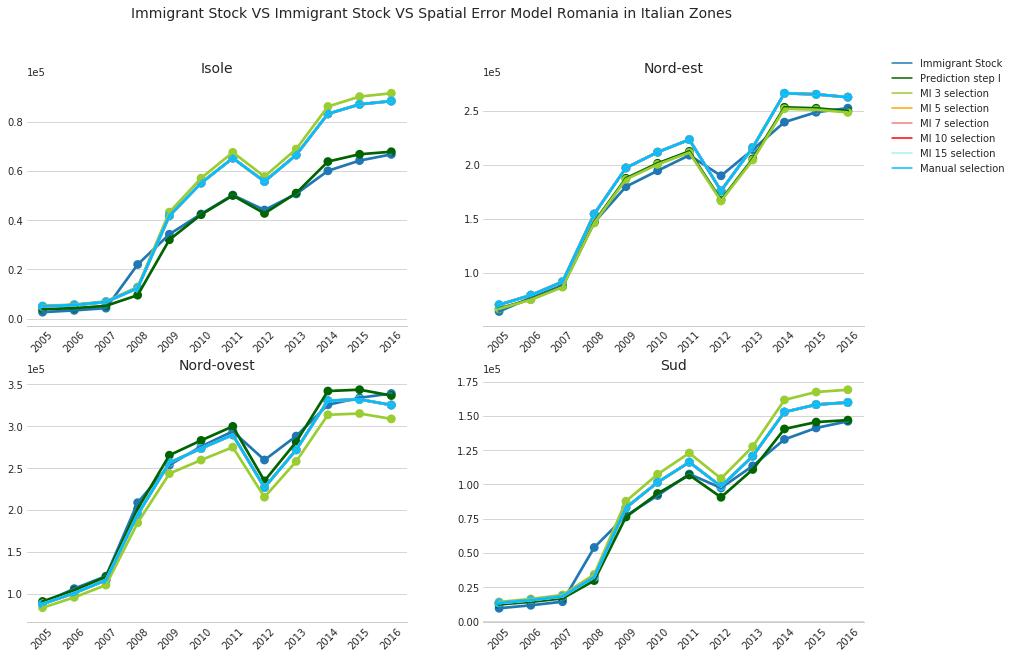

R-squared for Prediction step I 0.993000.
R-squared for MI 3 selection 0.972000.
R-squared for MI 5 selection 0.983000.
R-squared for MI 7 selection 0.983000.
R-squared for MI 10 selection 0.983000.
R-squared for MI 15 selection 0.983000.
R-squared for Manual selection 0.983000.


In [18]:
vars_ = [["Free activities in voluntary associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "internal_migration - Italy", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Post offices", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]
res_pred, res_params = run_model(y, "Romania", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

In [20]:
vars_ = [["native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Disposable Income", 
  "political_info - Every day"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Born alive", "Disposable Income", 
  "political_info - Every day", "reach_difficulty - Supermarket"], 
 ["Free activities in voluntary associations", "internal_migration - Foreign country", 
  "native population - Total", "Free activities in non voluntary associations", 
  "Meetings in cultural, recreational or other associations", "political_info - Never", 
  "political_info - Some times in a week", "Pay money to an association", "reach_difficulty - Supermarket", 
  "reach_difficulty - Pharmacy", "Born alive", "Disposable Income", "political_info - Every day"], 
 ["native population - Total", "Free activities in voluntary associations", 
  "Meetings in cultural, recreational or other associations", "Disposable Income", 
  "Average monthly expenditure for housing", "unemployment - Total", "reach_difficulty - Emergency room"]]

In [ ]:
res_pred, res_params = run_model(y, "Albania", years, "Centro", xs, temp_W, sorted(list(set(zones_data.Zona))), vars_, False, palette, "Spatial Error Model", save = False)

---------- Step I ----------
Current time: 10:19:58
Optimization terminated successfully.
Current time: 10:21:22
Computational time: 0:01:24.269132
---------- Step II ----------
